# Generating Tom Cruise Images with DQD Algorithms

_Lights! Camera! Action!_

In recent years, there has been an explosion in AI's ability to understand and manipulate images and text. In particular, with the rise of [Generative Adversarial Networks (GANs)](https://en.wikipedia.org/wiki/Generative_adversarial_network) like [StyleGAN](https://en.wikipedia.org/wiki/StyleGAN), AI can now generate fake yet highly realistic images. Incredibly, even something as complex as a human face can now be reproduced with ease, as demonstrated by websites like [this person does not exist](https://thispersondoesnotexist.com) and [which face is real](https://www.whichfaceisreal.com/index.php).

Yet, one problem which GANs face is that they can be difficult to control. For instance, suppose we wanted to generate an image of a specific person, say, a famous celebrity like Tom Cruise. To accomplish this task, we would need to find a latent vector $z$, such that when we pass $z$ into the GAN's generator, it outputs an image of the actor. However, finding $z$ is not straightforward. Typical GAN latent spaces are not interpretable, i.e., there is no sign saying "use this $z$ to get an image of Tom Cruise." Hence, we would have to try at least a few vectors. But trying out all these vectors brings us to our second problem: how do we check that the images we generate actually show Tom Cruise? Surely, we can't sit around looking at every single image created — Tom Cruise will have filmed his next movie by then!

Fortunately, that's where another major advance in AI comes in. At the same time that GANs have learned to generate all kinds of fake images, models like [CLIP](https://openai.com/blog/clip/) have learned to seamlessly associate text with images. Essentially, CLIP takes in a piece of text (a "prompt") and an image and tells how similar they are. And this is exactly what we need for our problem: given the prompt "Tom Cruise" and an image generated by our GAN, CLIP will tell us whether the image indeed shows our beloved actor.

The diagram below demonstrates our pipeline. We pass a latent vector $z$ to StyleGAN (our choice of GAN), then we pass the output of StyleGAN to CLIP along with the prompt "Tom Cruise." CLIP outputs a score, and once we backpropagate through the networks, we get a gradient $\nabla_z f$. By performing gradient descent, we can update $z$ so that we gradually generate more realistic images of Tom Cruise. Such a pipeline has been successfully implemented in this wonderful [blog post](https://towardsdatascience.com/generating-images-from-prompts-using-clip-and-stylegan-1f9ed495ddda) by Victor Perez.

![The StyleGAN+CLIP Pipeline](_static/stylegan-clip.png)

While this pipeline works splendidly, it has a key limitation, in that it can only generate one picture at a time. Yet, we know there are many possible images of Tom Cruise; for instance, he has sported different hairstyles throughout his long acting career.

That's where the concept of latent space illumination (LSI) comes in. [Introduced in 2021](https://arxiv.org/abs/2007.05674), LSI  uses QD algorithms to search for a diverse collection of images in a GAN's latent space. To frame our current problem as a QD problem, we can set our objective to be to find an image of Tom Cruise, and we can set our measures to be (1) the length of Tom Cruise's hair and (2) the age of Tom Cruise, with the measures computed with CLIP just like the objective is. By solving this QD problem, we will end up with an archive consisting of different images of Tom Cruise, like the one shown below.

![Outputs of an LSI algorithm searching for images of Tom Cruise](_static/tom-cruise-archive.png)

Given what we know so far, we could perform this search with CMA-ME or CMA-MAE. However, an important property of this problem is that the objective and measures are differentiable — recall that the original pipeline above used gradient descent to modify $z$. The presence of gradients makes this a differentiable quality diversity (DQD) problem. Compared to derivative-free algorithms like CMA-ME and CMA-MAE, DQD algorithms are typically much more efficient, as they are able to leverage gradients to guide themselves around the search space.

In this tutorial, we will apply DQD algorithms to search for images of Tom Cruise. Specifically, we will implement the DQD algorithm Covariance Matrix Adaptation MAP-Elites via a Gradient Arborescence (CMA-MEGA), introduced in [Fontaine 2021](https://arxiv.org/abs/2106.03894), and run it with the StyleGAN+CLIP pipeline described above.

_This tutorial assumes that you are familiar with Covariance Matrix Adaptation MAP-Elites (CMA-ME). If you are not yet familiar with CMA-ME, we recommend reviewing our [Lunar Lander tutorial](https://docs.pyribs.org/en/stable/tutorials/lunar_lander.html). And for more on latent space illumination, refer to our [LSI MNIST tutorial](https://docs.pyribs.org/en/stable/tutorials/lsi_mnist.html) which generates diverse MNIST digits._

## Setup

Since StyleGAN and CLIP are fairly large models, you will need a GPU to run this tutorial (running on Colab should work fine). Below, we check what GPU has been provided. The possible GPUs (at the time of writing) are as follows; factory reset the runtime if you do not have the desired GPU.

* V100 = Excellent (*Available only for Colab Pro users*)
* P100 = Very Good
* T4 = Good (*preferred*)
* K80 = Meh
* P4 = (*Not Recommended*) 

In [53]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f1ba8be3-178c-e5cf-9dca-288b9783e5f4)


Now, we install various libraries. This cell will take around 5 minutes to run since it involves downloading several large files.

In [54]:
#@title #**Install libraries** 🏗️
# @markdown This cell will take around 5 minutes to download several libraries.

!pip install --upgrade torch==1.9.1+cu111 torchvision==0.10.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
# !git clone https://github.com/autonomousvision/stylegan_xl
!git clone https://github.com/openai/CLIP
!pip install -e ./CLIP
!pip install einops ninja
!pip install timm

!curl -LO 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-ffhq-256x256.pkl'
!git clone https://github.com/icaros-usc/pyribs.git
!pip install ./pyribs[all]

import sys
sys.path.append("./CLIP")
sys.path.append("./stylegan2-ada-pytorch")
# sys.path.append('./stylegan_xl')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
fatal: destination path 'stylegan2-ada-pytorch' already exists and is not an empty directory.
fatal: destination path 'CLIP' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/CLIP
  Attempting uninstall: clip
    Found existing installation: clip 1.0
    Can't uninstall 'clip'. No files were found to uninstall.
  Running setup.py develop for clip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   

In [55]:
#@title #**Import Python Modules** 🐍

import io
import os, time, glob
import pickle
import shutil
from pathlib import Path
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import clip
import unicodedata
import re
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange

import csv
import matplotlib.pyplot as plt
import pandas as pd

from ribs.archives import GridArchive
from ribs.emitters import GradientArborescenceEmitter
from ribs.schedulers import Scheduler
from ribs.visualize import grid_archive_heatmap

In [56]:
#@title #**Define necessary Functions** 🛠️
def tensor_to_pil_img(img):
    img = (img.clamp(-1, 1) + 1) / 2.0
    img = img[0].permute(1, 2, 0).detach().cpu().numpy() * 255
    img = Image.fromarray(img.astype('uint8'))
    return img

def norm1(prompt):
    return prompt / prompt.square().sum(dim=-1, keepdim=True).sqrt()

def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

def cos_sim_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().mul(2)

def prompts_dist_loss(x, targets, loss):
    if len(targets) == 1: # Keeps consistent results vs previous method for single objective guidance 
      return loss(x, targets[0])
    distances = [loss(x, target) for target in targets]
    loss = torch.stack(distances, dim=-1).sum(dim=-1)
    return loss

def save_heatmap(archive, heatmap_path):
    """Saves a heatmap of the archive to the given path.
    Args:
        archive (GridArchive): The archive to save.
        heatmap_path: Image path for the heatmap.
    """
    plt.figure(figsize=(8, 6))
    grid_archive_heatmap(archive, vmin=0, vmax=100, cmap="viridis")
    plt.tight_layout()
    plt.savefig(heatmap_path)
    plt.close(plt.gcf())

In [57]:
#@title #**Connect Text and Images using CLIP** 🛠️
transform = transforms.CenterCrop(224)

class CLIP:
    def __init__(self, device='cpu'):
        self.device = device
        clip_model_name = "ViT-B/32"
        self.model, _ = clip.load(clip_model_name, device=device)
        self.model = self.model.requires_grad_(False)
        self.model.eval()
        self.normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                              std=[0.26862954, 0.26130258, 0.27577711])

    @torch.no_grad()
    def embed_text(self, prompt):
        return norm1(self.model.encode_text(clip.tokenize(prompt)
               .to(self.device)).float())

    def embed_cutout(self, image):
        return norm1(self.model.encode_image(self.normalize(image)))

    def embed_image(self, image):
        n = image.shape[0]
        centered_img = transform(image)
        embeds = self.embed_cutout(centered_img)
        embeds = rearrange(embeds, '(cc n) c -> cc n c', n=n)
        return embeds

In [58]:
#@title #**Create STYLE-GAN2 Model** 🎭
class Generator(object):

    def __init__(self, device='cpu'):
        self.device = device
        model_filename = './stylegan2-ffhq-256x256.pkl'
        with open(model_filename, 'rb') as fp:
            self.model = pickle.load(fp)['G_ema'].to(device)
            self.model.eval()
        for p in self.model.parameters():
            p.requires_grad_(False)
        self.init_stats()
        self.latent_shape = (-1, 512)

    def init_stats(self):
        zs = torch.randn([10000, self.model.mapping.z_dim], device=self.device)
        ws = self.model.mapping(zs, None)
        self.w_stds = ws.std(0)
        qs = ((ws - self.model.mapping.w_avg) / self.w_stds).reshape(10000, -1)
        self.q_norm = torch.norm(qs, dim=1).mean() * 0.35

    def gen_random_ws(self, num_latents):
        zs = torch.randn([num_latents, self.model.mapping.z_dim], device=self.device)
        ws = self.model.mapping(zs, None)
        return ws

In [59]:
#@title #**Classifier with Objective and Measures** 🕵️

class Classifier(object):

    def __init__(self, gen_model, class_model, prompt):
        self.device = gen_model.device
        self.gen_model = gen_model
        self.class_model = class_model
        self.measures = []

        self.init_objective(f'A photo of the face of {prompt}.')
        self.add_measure(f'A photo of {prompt} as a small child.', 
                         f'A photo of {prompt} as an elderly person.')
        self.add_measure(f'A photo of {prompt} with long hair.', 
                         f'A photo of {prompt} with short hair.')

    def init_objective(self, text_prompt):
        texts = [frase.strip() for frase in text_prompt.split("|") if frase]
        self.obj_targets = [self.class_model.embed_text(text) for text in texts]

    def add_measure(self, positive_text, negative_text):
        texts = [frase.strip() for frase in positive_text.split("|") if frase]
        negative_targets = [self.class_model.embed_text(text) for text in texts]
        
        texts = [frase.strip() for frase in negative_text.split("|") if frase]
        positive_targets = [self.class_model.embed_text(text) for text in texts]
        
        self.measures.append((negative_targets, positive_targets))

    def find_good_start_latent(self, batch_size=16, num_batches=32):
        with torch.inference_mode():
            qs = []
            losses = []
            G = self.gen_model.model
            w_stds = self.gen_model.w_stds
            for _ in range(num_batches):
                q = (G.mapping(torch.randn([batch_size, G.mapping.z_dim], device=self.device),
                    None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
                images = G.synthesis(q * w_stds + G.mapping.w_avg)
                embeds = self.class_model.embed_image(images.add(1).div(2))
                loss = prompts_dist_loss(embeds, self.obj_targets, spherical_dist_loss).mean(0)
                i = torch.argmin(loss)
                qs.append(q[i])
                losses.append(loss[i])
            qs = torch.stack(qs)
            losses = torch.stack(losses)

            i = torch.argmin(losses)
            q = qs[i].unsqueeze(0)

        return q.flatten()

    def generate_image(self, latent_code):
        ws, _ = self.transform_to_w([latent_code])
        images = self.gen_model.model.synthesis(ws, noise_mode='const')
        return images

    def transform_to_w(self, latent_codes):
        qs = []
        ws = []
        for cur_code in latent_codes:
            q = torch.tensor(
                    cur_code.reshape(self.gen_model.latent_shape), 
                    device=self.device,
                    requires_grad=True,
                )
            qs.append(q)
            w = q * self.gen_model.w_stds + self.gen_model.model.mapping.w_avg
            ws.append(w)

        ws = torch.stack(ws, dim=0)
        return ws, qs

    def compute_objective_loss(self, embeds, qs, dim=None):
        loss = prompts_dist_loss(embeds, self.obj_targets, spherical_dist_loss).mean(0)

        diff = torch.max(torch.norm(qs, dim=dim), self.gen_model.q_norm)
        reg_loss = (diff - self.gen_model.q_norm).pow(2)
        loss = loss + 0.2* reg_loss

        return loss

    def compute_objective(self, sols):
        ws, qs = self.transform_to_w(sols)

        images = self.gen_model.model.synthesis(ws, noise_mode='const')
        embeds = self.class_model.embed_image(images.add(1).div(2))
    
        loss = self.compute_objective_loss(embeds, qs[0])
        loss.backward()

        value = loss.cpu().detach().numpy()
        jacobian = -qs[0].grad.cpu().detach().numpy()
        return value, jacobian.flatten()

    def compute_measure(self, index, sols):
        ws, qs = self.transform_to_w(sols)

        images = self.gen_model.model.synthesis(ws, noise_mode='const')
        embeds = self.class_model.embed_image(images.add(1).div(2))

        measure_targets = self.measures[index]
        pos_loss = prompts_dist_loss(embeds, measure_targets[0], cos_sim_loss).mean(0)
        neg_loss = prompts_dist_loss(embeds, measure_targets[1], cos_sim_loss).mean(0)
        loss = pos_loss - neg_loss
        loss.backward()

        value = loss.cpu().detach().numpy()
        jacobian = qs[0].grad.cpu().detach().numpy()
        return value, jacobian.flatten()

    def compute_measures(self, sols):
    
        values = []
        jacobian = []
        for i in range(len(self.measures)):
            value, jac = self.compute_measure(i, sols)
            values.append(value)
            jacobian.append(jac)

        return np.stack(values, axis=0), np.stack(jacobian, axis=0)

    def compute_all(self, sols):
        with torch.inference_mode():

            ws, qs = self.transform_to_w(sols)
            qs = torch.stack(qs, dim=0)

            images = self.gen_model.model.synthesis(ws, noise_mode='const')
            embeds = self.class_model.embed_image(images.add(1).div(2))
            
            values = []
            loss = self.compute_objective_loss(embeds, qs, dim=(1,2))
            value = loss.cpu().detach().numpy()
            values.append(value)

            for i in range(len(self.measures)):
                measure_targets = self.measures[i]
                pos_loss = prompts_dist_loss(
                        embeds, 
                        measure_targets[0], 
                        cos_sim_loss,
                    ).mean(0)
                neg_loss = prompts_dist_loss(
                        embeds, 
                        measure_targets[1], 
                        cos_sim_loss
                    ).mean(0)
                loss = pos_loss - neg_loss
                value = loss.cpu().detach().numpy()
                values.append(value)

        return np.stack(values, axis=0)

In [60]:
#@title **Optimizer with GradientArborescence** 🏆
#@markdown To solve DQD, we introduce the concept of a gradient arborescence. Like gradient ascent, a gradient arborescence makes greedy ascending steps based on the objective. Unlike gradient ascent, a gradient arborescence encourages exploration by branching via the measures $m_i$

#@markdown This emitter originates in  [Fontaine 2021](https://arxiv.org/abs/2106.03894). It leverages the gradient information of the objective and measure functions, generating new solutions around a "solution point" using gradient arborescence with coefficients drawn from a Gaussian distribution. 

#@markdown Based on how the solutions are ranked after being inserted into the archive, the solution point is updated with gradient ascent, and the distribution is updated with CMA-ES.


measure_space_bounds =[(-0.2, 0.2), (-0.2, 0.2)]

def transform_obj(objs):
    # Remap the objective from minimizing [0, 10] to maximizing [0, 100]
    return (10.0-objs*5.0)*10.0


def create_optimizer(algorithm, classifier, seed):
    """Creates an optimizer based on the algorithm name.

    Args:
        algorithm (str): Name of the algorithm passed into sphere_main.
        classifier (Classifier): The models for the search.
        seed (int): Main seed or the various components.
    Returns:
        Scheduler: A ribs Scheduler for running the algorithm.
    """
    bounds = measure_space_bounds
    initial_sol = classifier.find_good_start_latent().cpu().detach().numpy()
    dim = len(initial_sol)
    batch_size = 32
    num_emitters = 1
    resolution = 200
    grid_dims = (resolution, resolution)

    # Create archive.
    archive = GridArchive(
        solution_dim = dim,
        dims=grid_dims, 
        ranges=bounds, 
        learning_rate=0.02,
        threshold_min=0.0,
        seed=seed
    )

    # Maintain a result elitist archive
    result_archive = GridArchive(
        solution_dim = dim,
        dims=grid_dims,
        ranges=bounds,
        seed=seed
    )

    # Create emitters. Each emitter needs a different seed, so that they do not
    # all do the same thing.
    emitter_seeds = [None] * num_emitters if seed is None else list(
        range(seed, seed + num_emitters))
    emitters = [
        GradientArborescenceEmitter(
            archive=archive,
            x0=initial_sol,
            sigma0=0.01,
            lr=0.05,
            ranker="imp",
            selection_rule="mu",
            restart_rule='basic',
            batch_size=batch_size,
            seed=s,
        ) for s in emitter_seeds
    ]

    return Scheduler(archive, emitters, result_archive= result_archive)

In [61]:
# Initialization.
#@markdown #**Parameters** ✍️
#@markdown `prompt`: Enter a prompt of a Celebrity here to guide the image generation.

prompt = "Tom Cruise"#@param {type:"string"}

#@markdown ---
outdir='logs'
            
# Create a shared logging directory for the experiments for this algorithm.
s_logdir = os.path.join(outdir, "cma_maega")
logdir = Path(s_logdir)
outdir = Path(outdir)
if not outdir.is_dir():
    outdir.mkdir()
if not logdir.is_dir():
    logdir.mkdir()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.cuda.empty_cache()

clip_model = CLIP(device=device)
gen_model = Generator(device=device)
classifier = Classifier(gen_model, clip_model, prompt=prompt)

In [62]:
#@markdown #**Run the model** 🚀
#@markdown #Will take ~10 minutes per 1000 iterations
#StyleGAN+CLIP LSI experiments.
trials=1
init_pop=100
total_itrs=3000
log_freq=1
log_arch_freq=1000
image_monitor=True
image_monitor_freq=10
seed=None

for trial_id in range(trials):
    print("Running trial", trial_id)
    # Create a directory for this specific trial.
    s_logdir = os.path.join(outdir, "cma_maega", f"trial_{trial_id}")
    logdir = Path(s_logdir)
    if not logdir.is_dir():
        logdir.mkdir()

    # Create a directory for logging intermediate images if the monitor is on.
    if image_monitor:
        image_monitor_freq = max(1, image_monitor_freq)
        gen_output_dir = os.path.join('generations')
        logdir = Path(gen_output_dir)
        if not logdir.is_dir():
            logdir.mkdir()
        gen_output_dir = os.path.join('generations', f"trial_{trial_id}")
        logdir = Path(gen_output_dir)
        if not logdir.is_dir():
            logdir.mkdir()

    # Create a new summary file
    summary_filename = os.path.join(s_logdir, "summary.csv")
    if os.path.exists(summary_filename):
        os.remove(summary_filename)
    with open(summary_filename, 'w') as summary_file:
        writer = csv.writer(summary_file)
        writer.writerow(['Iteration', 'QD-Score', 'Coverage', 'Maximum', 'Average'])
    
    scheduler = create_optimizer(algorithm="cma_maega", classifier=classifier,seed = seed)
    archive = scheduler.archive

    best = -1000
    non_logging_time = 0.0
    for itr in tqdm(range(1, total_itrs + 1)):
        itr_start = time.time()
        
        sols = scheduler.ask_dqd()
        objs, jacobian_obj = classifier.compute_objective(sols)
        objs = transform_obj(objs)
        best = max(best, objs)

        measures, jacobian_measure = classifier.compute_measures(sols)

        jacobian_obj = np.expand_dims(jacobian_obj, axis=0)
        jacobian = np.concatenate((jacobian_obj, jacobian_measure), axis=0)
        jacobian = np.expand_dims(jacobian, axis=0)

        measures = np.transpose(measures) 

        objs = objs.astype(np.float32)
        measures = measures.astype(np.float32)
        jacobian = jacobian.astype(np.float32)

        scheduler.tell_dqd(objs, measures, jacobian)

        sols = scheduler.ask()
        values = classifier.compute_all(sols)
        values = np.transpose(values)

        objs = values[:,0]
        measures = values[:,1:3]

        objs = transform_obj(np.array(objs, dtype=np.float32))
        measures = np.array(measures, dtype=np.float32)
        
        best_gen = max(objs) 
        best = max(best, best_gen)

        scheduler.tell(objs, measures)

        non_logging_time += time.time() - itr_start

        if itr%50 == 0:
          print('best', best, best_gen)

        if image_monitor and itr % image_monitor_freq == 0:
            best_index = np.argmax(objs)
            latent_code = sols[best_index]

            img = classifier.generate_image(latent_code)
            img = tensor_to_pil_img(img)
            img.save(os.path.join(gen_output_dir, f'{itr}.png'))

        # Save the archive at the given frequency.
        # Always save on the final iteration.
        final_itr = itr == total_itrs
        result_archive = scheduler.result_archive
        if (itr > 0 and itr % log_arch_freq == 0) or final_itr:
            # Save a full archive for analysis.
            df = result_archive.as_pandas(include_solutions = final_itr)
            df.to_pickle(os.path.join(s_logdir, f"archive_{itr:08d}.pkl"))

            # Save a heatmap image to observe how the trial is doing.
            save_heatmap(result_archive, os.path.join(s_logdir, f"heatmap_{itr:08d}.png"))

        # Update the summary statistics for the archive
        if (itr > 0 and itr % log_freq == 0) or final_itr:
            with open(summary_filename, 'a') as summary_file:
                writer = csv.writer(summary_file)
                stats = result_archive.stats
                qd_score = stats.qd_score/result_archive.cells 
                average = stats.obj_mean
                coverage = stats.coverage
                data = [itr, qd_score, coverage, best, average]
                writer.writerow(data)

Running trial 0


  0%|          | 0/3000 [00:00<?, ?it/s]

best 66.31585 66.17257
best 67.55726 66.878746
best 67.55726 67.25772
best [68.34775] 67.375854
best [68.34775] 66.64097
best [68.34775] 66.955215
best [68.34775] 67.57489
best 68.75427 67.49671
best 68.75427 66.396706
best 68.75427 67.67209
best 68.75427 68.64873
best 68.75427 67.26511
best 68.75427 68.05152
best 68.75427 66.488075
best 68.75427 67.07869
best 68.75427 66.92888
best 68.75427 67.203804
best 68.75427 67.64382
best 68.75427 67.82922
best 68.75427 65.62446
best 68.75427 65.59175
best 68.75427 67.29975
best 68.75427 65.978134
best 68.75427 67.59679
best [69.0689] 66.429695
best [69.0689] 66.53856
best [69.0689] 67.43003
best [69.0689] 67.90415
best [69.0689] 65.24788
best [69.0689] 67.5601
best [69.0689] 67.65982
best [69.0689] 66.86048
best [69.0689] 67.355804
best [69.0689] 68.59894
best [69.0689] 68.159676
best [69.0689] 66.430115
best [69.0689] 68.69635
best 69.085526 61.525276
best 69.085526 63.684673
best 69.085526 63.2455
best 69.085526 66.27875
best 69.085526 66.125

<ipython-input-64-49affcea77b0>:114: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


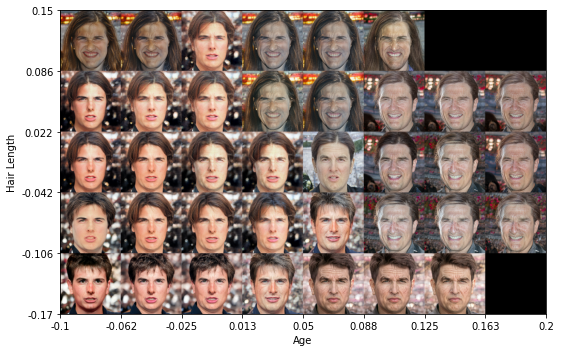

In [64]:
#@markdown #**Create a Collage** 📸

archive_filename = './logs/cma_maega/trial_0/archive_00003000.pkl'

# Controls that x rows and y columns are generated
# Images are "evenly" (as possible) sampled based on this criteria
picture_frequency = (8, 5) 

# Use the CPU while we are running exps.
#device = "cpu"
device = "cuda"

# Uncomment to save all grid images separately.
gen_output_dir = os.path.join('grid_imgs')
logdir = Path(gen_output_dir)
if not logdir.is_dir():
    logdir.mkdir()

model_filename = './stylegan2-ffhq-256x256.pkl'
with open(model_filename, 'rb') as fp:
    model = pickle.load(fp)['G_ema'].to(device)
    model.eval()
latent_shape = (1, -1, 512)

zs = torch.randn([10000, model.mapping.z_dim], device=device)
ws = model.mapping(zs, None)
w_stds = ws.std(0)
qs = ((ws - model.mapping.w_avg) / w_stds).reshape(10000, -1)
q_norm = torch.norm(qs, dim=1).mean() * 0.1

# Read the archive from the log (pickle file)
df = pd.read_pickle(archive_filename)
# print(df.describe()) 

measure_bounds = [(round(df['measure_0'].min(), 2), round(df['measure_0'].max(), 2)),
                  (round(df['measure_1'].min(), 2), round(df['measure_1'].max(), 2))]

imgs = []
delta_measure_0 = round((measure_bounds[0][1] - measure_bounds[0][0])/picture_frequency[0], 2)
delta_measure_1 = round((measure_bounds[1][1] - measure_bounds[1][0])/picture_frequency[1], 2)

for j in range(picture_frequency[1]):
  for i in range(picture_frequency[0]):
        measure_0_low = round(measure_bounds[0][0] + delta_measure_0*i, 2)
        measure_0_high = round(measure_bounds[0][0] + delta_measure_0*(i+1), 2)
        measure_1_low = round(measure_bounds[1][0] + delta_measure_1*j, 2)
        measure_1_high = round(measure_bounds[1][0] + delta_measure_1*(j+1), 2)

        query_string = f"{measure_0_low} <= measure_0 & measure_0 <= {measure_0_high} & "
        query_string += f"{measure_1_low} <= measure_1 & measure_1 <= {measure_1_high}" 

        # print(query_string)
        df_cell = df.query(query_string)
        # print(df_cell)

        if not df_cell.empty:
          sol = df_cell.iloc[df_cell['objective'].argmax()]

          q = torch.tensor(
                  sol[4:].values.reshape(latent_shape),
                  device=device,
                  requires_grad=True,
              )
          w = q * w_stds + model.mapping.w_avg

          img = model.synthesis(w, noise_mode='const')
          img = (img.clamp(-1, 1) + 1) / 2.0 # Normalize from [0,1]

          pil_img = img[0].permute(1, 2, 0).detach().cpu().numpy() * 255
          pil_img = Image.fromarray(pil_img.astype('uint8'))
          pil_img.save(os.path.join(gen_output_dir, f'{j}_{i}.png'))

          img = img[0].detach().cpu()
          imgs.append(img)
        else:
          imgs.append(torch.zeros((3,256,256)))

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

plt.figure(figsize=picture_frequency)
img_grid = make_grid(imgs, nrow=picture_frequency[0], padding=0)
img_grid = np.transpose(img_grid.cpu().numpy(), (1,2,0))
plt.imshow(img_grid)

plt.xlabel("Age")
plt.ylabel("Hair Length")

def create_archive_tick_labels(measure_range, num_ticks):
    low_pos = measure_range[0]
    high_pos = measure_range[1]

    delta = (measure_range[1]-measure_range[0])/num_ticks

    ticklabels = [
        round( delta*p + measure_range[0], 3)
        for p in range(num_ticks+1)
    ]
    return ticklabels

num_x_ticks = picture_frequency[0]
num_y_ticks = picture_frequency[1]
x_ticklabels = create_archive_tick_labels( measure_bounds[0], num_x_ticks)
y_ticklabels = create_archive_tick_labels(measure_bounds[1], num_y_ticks)
y_ticklabels.reverse()

x_tick_range = img_grid.shape[1]
x_ticks = np.arange(0, x_tick_range+1e-9, step=x_tick_range/num_x_ticks)
y_tick_range = img_grid.shape[0]
y_ticks = np.arange(0, y_tick_range+1e-9, step=y_tick_range/num_y_ticks)
plt.xticks(x_ticks, x_ticklabels)
plt.yticks(y_ticks, y_ticklabels)
plt.tight_layout()
ax = plt.axes()
ax.set_facecolor("white")
plt.savefig('collage.jpg')

## Citation

If you find this tutorial useful, please cite it as:

```text
@article{pyribs_tom_cruise_dqd,
  title   = {Generating Tom Cruise Images with DQD Algorithms},
  author  = {Nivedit Reddy Balam and Bryon Tjanaka and David H. Lee and Matthew C. Fontaine and Stefanos Nikolaidis},
  journal = {pyribs.org},
  year    = {2023},
  url     = {https://docs.pyribs.org/en/stable/tutorials/tom_cruise_dqd.html}
}
```